In [1]:
import sys 
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from NN import network, activation_functions, loss_functions
from NN import ANN


/root/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Introduction 
This notebook was made as a base for the Neural Network implementation and tests. 
The target values for the net and output for each layers follows bellow: 
```
Input Layer:
[0.05, 0.10]

Hidden Layer:
Weigths [0.15, 0.2] [0.25, 0.3]
Net [0.3775 0.3925]
Out [0.59326999 0.59688438] (softmax)
Grad [[0.14978072 0.24950229] [0.19978072 0.29950229]]

Output Layer:
[[0.4, 0.45], [0.50, 0.55]]
Net [1.10590597 1.2249214 ]
Out [0.75136507 0.77292847]] (softmax)
Grad 



MSD = 0.2983711
```


In [2]:
# Target Values 
# Hidden Layer:
_NetH = np.array([[0.3775, 0.3925]])
_OutH = np.array([[0.59326999, 0.59688438]])

# Output Layer:
_NetO = np.array([[1.10590597, 1.2249214 ]])
_OutO = np.array([[0.75136507, 0.77292847]])

_MSD = 0.2983711
_error_accepted = 0.00000001

In [3]:
def compare_arrays(A, B, eps=_error_accepted): 
    return (A - B).sum() < eps

## Layer by Layer Validation
To identify if there is no code broken

In [4]:
from importlib import reload
reload(network)
I = np.array([[0.05, 0.10]])
W = np.array([[0.15, 0.2], [0.25, 0.3]]).T
h1 = network.Layer(2, 2, 'sigmoid', weights=W, bias=0.35, label="H1")
netH, outH =  h1.feed_forward(I)
print(netH)
print(outH)
assert(compare_arrays(netH, _NetH))
assert(compare_arrays(outH, _OutH))

[[0.3775 0.3925]]
[[0.59326999 0.59688438]]


In [5]:
from importlib import reload
reload(network)
I = np.array([[0.59326999, 0.59688438]])
W = np.array([[0.4, 0.45], [0.50, 0.55]]).T
o1 = network.Layer(2, 2, 'sigmoid', weights=W, bias=0.6, label="H1")
netO, outO =  o1.feed_forward(I)
print(netO)
print(outO)
assert(compare_arrays(netO, _NetO))
assert(compare_arrays(outO, _OutO))

[[1.10590597 1.2249214 ]]
[[0.75136507 0.77292847]]


# Convergence Checkings
Based on the sample given by the class teacher

## Manual Calculations

In [6]:
from importlib import reload
reload(network)
model = network.NN(loss='smd')
X = np.array([[0.05, 0.10]])

Wh = np.array([[0.15, 0.2], [0.25, 0.3]]).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]]).T
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="H1")
model.add_layer(h)
model.add_layer(o)
model.show_weights()

Y, aY = model.feed_forward(X)
Y_, aY_ = ([1.10590597, 1.2249214 ], [0.75136507, 0.77292847])
print("Y\n",Y_)
print("\na(Y)\n",aY_)

assert(compare_arrays(Y, Y_))
assert(compare_arrays(aY, aY_))


Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.25]
 [0.2  0.3 ]]
H1      (input=2, neurons=2, activation=sigmoid)
[[0.4  0.5 ]
 [0.45 0.55]]
-------------------------------
Y
 [1.10590597, 1.2249214]

a(Y)
 [0.75136507, 0.77292847]


### Working on the back propagation

In [7]:
from importlib import reload
reload(network)
model.show_weights()
Y = np.array([0.01, 0.99])
Etotal = loss_functions.smd(aY, Y)
print(Etotal)
assert((Etotal - _MSD) < np.finfo(np.float32).eps)

Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.25]
 [0.2  0.3 ]]
H1      (input=2, neurons=2, activation=sigmoid)
[[0.4  0.5 ]
 [0.45 0.55]]
-------------------------------
0.2983711087600027


### Emulating the weights update for the layer O 

In [8]:
reload(loss_functions)
reload(activation_functions)
lr = 0.5
#Done - Partial
dEo_dw = loss_functions.smd_derivative_chain(outO, Y)
print(dEo_dw)

# Done
dOuto_Dneto = activation_functions.sigmoid_derivative_chain(outO)
print('dout',dOuto_Dneto)

# Done - Self.input
dNeto  = outH
print('dnet',dNeto) 
# Done
deltaO  = dEo_dw * dOuto_Dneto
print('delta', deltaO)

dWO = deltaO * outH
print('dw', dWO)
# Done
updateO = Wo - lr * dWO
print('update', updateO)

[[ 0.74136507 -0.21707153]]
dout [[0.1868156  0.17551005]]
dnet [[0.59326999 0.59688438]]
delta [[ 0.13849856 -0.03809824]]
dw [[ 0.08216704 -0.02274024]]
update [[0.35891648 0.51137012]
 [0.40891648 0.56137012]]


In [9]:
#
# Done - Partial
dEo_dOh = deltaO * Wo
dETotal_dOh = dEo_dOh.sum(axis=1)
print (dEo_dOh)
print('dETotal_dOh', dETotal_dOh)

# Done
dOuth_Dneth = activation_functions.sigmoid_derivative_chain(outH)
print('dOuth_Dneth', dOuth_Dneth)


# Done
deltaH = dETotal_dOh * dOuth_Dneth 
print('deltaH', deltaH)

# done
# self.input
dNeth_dw = X
dWh = deltaH * dNeth_dw
print('dWh', dWh)

# Done
updateH = Wh - lr * dWh
print('update', updateH)

[[ 0.05539942 -0.01904912]
 [ 0.06232435 -0.02095403]]
dETotal_dOh [0.03635031 0.04137032]
dOuth_Dneth [[0.24130071 0.24061342]]
deltaH [[0.00877135 0.00995425]]
dWh [[0.00043857 0.00099543]]
update [[0.14978072 0.24950229]
 [0.19978072 0.29950229]]


## Using the implemented Grad calculation for Layers

In [10]:
reload(loss_functions)
reload(activation_functions)
reload(network)
network.DEBUG = True

X = np.array([[0.05, 0.10], [0.05, 0.10]], np.float64)
Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]],  np.float64).T
o = network.Layer(2, 2, 'sigmoid', bias=0.6, weights=Wo, label="O")
Y = np.array([[0.01, 0.99], [0.01, 0.99]], np.float64)

for i in range(1):
    netH, outH = h.feed_forward(X)
    netO, outO = o.feed_forward(outH)

    
    Etotal = loss_functions.smd(outO, Y)
    if (i % 1000) == 0:
        print(i, 'error', Etotal)
    
    dEo_dw = loss_functions.smd_derivative_chain(outO, Y)
    
    network.dprint(dEo_dw)
    network.dprint ("")
    network.dprint ("==========================================")
    network.dprint ("Back Propagate Layer O")
    network.dprint ("==========================================")
    o.backpropagate(dETotal_dOut=dEo_dw)
    network.dprint ("==========================================")
    network.dprint ("")

    network.dprint ("==========================================")
    network.dprint ("Back Propagate Layer H")
    network.dprint ("==========================================")
    h.backpropagate(output_layer=o)
    network.dprint ("==========================================")

print (outO)

('net', array([[0.3775, 0.3925],
       [0.3775, 0.3925]]))
('out', array([[0.59326999, 0.59688438],
       [0.59326999, 0.59688438]]))
('net', array([[1.10590597, 1.2249214 ],
       [1.10590597, 1.2249214 ]]))
('out', array([[0.75136507, 0.77292847],
       [0.75136507, 0.77292847]]))
0 error 0.5967422175200054
[[ 0.74136507 -0.21707153]
 [ 0.74136507 -0.21707153]]

Back Propagate Layer O
('dETotal_dOut', array([[ 0.74136507, -0.21707153],
       [ 0.74136507, -0.21707153]]))

Back Propagate Layer H
('dETotal_dOut', None)
[[0.75136507 0.77292847]
 [0.75136507 0.77292847]]


# Using the Fit Methods with the full network calculation

## SMD as the Loss Function

In [11]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False
eps = 0.00001

X = np.array([[0.05, 0.10]], np.float64)
Y = np.array([[0.01, 0.99]], np.float64)

# Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 3, 'sigmoid', bias=0.35, label="H1")

# Wo = np.array([[0.4, 0.45], [0.50, 0.55]], np.float64).T
o = network.Layer(3, 2, 'sigmoid', bias=0.6, label="Output")

model = network.NN(loss='smd')
model.add_layer(h)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=50000, 
          lr=0.5, epsilon=eps, b_sz=2, 
          print_interval=2000)

_, Y_ = model.feed_forward(X)

mae = np.absolute(Y - Y_).mean()
print(Y_, mae)
assert(mae < 0.01)

Model Weights
-------------------------------
H1      (input=2, neurons=3, activation=sigmoid)
[[0.06873094 0.06779104 0.46651586]
 [0.9942668  0.79429204 0.2299453 ]]
Output  (input=3, neurons=2, activation=sigmoid)
[[0.62169732 0.87361974]
 [0.78269033 0.80376662]
 [0.29429575 0.2874628 ]]
-------------------------------
Shuffled
It: 2000 Batch: 1 Epoch 1999 Error: 0.00507939 lr: 0.500000 
It: 4000 Batch: 1 Epoch 3999 Error: 0.00014605 lr: 0.500000 
It: 6000 Batch: 1 Epoch 5999 Error: 0.00006126 lr: 0.500000 
It: 8000 Batch: 1 Epoch 7999 Error: 0.00003292 lr: 0.500000 
It: 10000 Batch: 1 Epoch 9999 Error: 0.00001986 lr: 0.500000 
It: 12000 Batch: 1 Epoch 11999 Error: 0.00001283 lr: 0.500000 
It: 14000 Batch: 1 Epoch 13999 Error: 0.00000866 lr: 0.500000 
Finished 
 It: 14001 Batch: 1 Epoch 14000 Train Loss: 0.00000866 lr: 0.500000 
[[0.01267919 0.98732663]] 0.002676279473026986


## Cross Entropy 

In [12]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False
eps = 0.0001
X = np.array([[0.05, 0.10]], np.float64)
Y = np.array([[0.01, 0.99]], np.float64)

Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]], np.float64).T
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=10000,
          lr=0.1, epsilon=eps, 
          print_interval=2000)

_, Y_ = model.feed_forward(X)

mae = np.absolute(Y - Y_).mean()
print(Y_, mae)
assert(mae < 0.01)

Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.25]
 [0.2  0.3 ]]
Output  (input=2, neurons=2, activation=sigmoid)
[[0.4  0.5 ]
 [0.45 0.55]]
-------------------------------
Shuffled
It: 2000 Batch: 1 Epoch 1999 Error: 0.76574643 lr: 0.100000 
It: 4000 Batch: 1 Epoch 3999 Error: 0.66248688 lr: 0.100000 
It: 6000 Batch: 1 Epoch 5999 Error: 0.65524647 lr: 0.100000 
It: 8000 Batch: 1 Epoch 7999 Error: 0.65246400 lr: 0.100000 
It: 10000 Batch: 1 Epoch 9999 Error: 0.65099797 lr: 0.100000 
Finished 
 It: 10000 Batch: 1 Epoch 9999 Train Loss: 0.65099797 lr: 0.100000 
[[0.0038555  0.99623122]] 0.006187855935083348


In [13]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False

eps = np.finfo(np.float32).eps

X = np.array([[0.05, 0.10], [0.05, 0.10], [0.10, 0.05]], np.float64)
Y = np.array([[0.0, 1], [0.0, 1], [1., 0.]], np.float64)

h1 = network.Layer(2, 10, 'sigmoid',  label="H1")
o = network.Layer(10, 2, 'sigmoid',  label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=50000, 
          lr=0.9, epsilon=eps,
          print_interval=2000)

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
Y = Y.argmax(axis=-1)
mae = np.absolute(Y - Y_).mean()
print(mae)
print(Y, Y_)
assert(mae < 0.1)

Model Weights
-------------------------------
H1      (input=2, neurons=10, activation=sigmoid)
[[0.34015892 0.3774501  0.55239781 0.21316383 0.18323073 0.71139699
  0.21324548 0.9789309  0.47268886 0.89950838]
 [0.02625534 0.05711932 0.96850331 0.99641186 0.671959   0.93450684
  0.74603043 0.39504565 0.356968   0.99335342]]
Output  (input=10, neurons=2, activation=sigmoid)
[[0.02965584 0.11591079]
 [0.40960434 0.54837269]
 [0.12947327 0.74444532]
 [0.549882   0.91837036]
 [0.81644862 0.97759646]
 [0.47140802 0.62939558]
 [0.2492737  0.80903289]
 [0.12812158 0.7763014 ]
 [0.63110963 0.48233425]
 [0.55560806 0.61378078]]
-------------------------------
Shuffled
It: 2000 Batch: 2 Epoch 666 Error: 1.28496579 lr: 0.900000 
It: 4000 Batch: 1 Epoch 1333 Error: 1.27898764 lr: 0.900000 
It: 6000 Batch: 3 Epoch 1999 Error: 1.24843647 lr: 0.900000 
It: 8000 Batch: 2 Epoch 2666 Error: 0.89221916 lr: 0.900000 
It: 10000 Batch: 1 Epoch 3333 Error: 0.67213904 lr: 0.900000 
It: 12000 Batch: 3 Epoch 3

# Multi class Classification Test

In [14]:
nclasses = 3
nsamples = 60000
nfeatures = 128

eps = np.finfo(np.float32).eps


vals = dataset_helper.get_toy_data_multiclass(nclasses, nsamples, nfeatures)
X,  _, _, _ = vals

epoch_sz = X.shape[0]
lr = 0.9
max_iter = 10 * epoch_sz
print_interval = 20*1000
decay_iteractions= 1 * epoch_sz
decay_rate = 0.8

## Using Cross Entropy as the Loss Function

Model Summary
-------------------------------
H1      (input=128, neurons=24, activation=tanh)
H2      (input=24, neurons=32, activation=tanh)
H3      (input=32, neurons=24, activation=tanh)
Output  (input=24, neurons=3, activation=sigmoid)
-------------------------------

Shuffled


../NN/activation_functions.py:41: RuntimeWarning: overflow encountered in exp
  return (2 / (1+np.exp(-2*h)))-1


It: 20000 Batch: 20000 Epoch 0 Train Loss: 1.90895007 lr: 0.900000 Val Loss: 1.89863641 Val Acc 0.47116667
It: 40000 Batch: 40000 Epoch 0 Train Loss: 1.57407436 lr: 0.900000 Val Loss: 1.35639041 Val Acc 0.78225000
It: 60000 Batch: 12000 Epoch 1 Train Loss: 1.33845516 lr: 0.720000 Val Loss: 1.33827933 Val Acc 0.83750000
It: 80000 Batch: 32000 Epoch 1 Train Loss: 1.31153297 lr: 0.720000 Val Loss: 1.31628546 Val Acc 0.81091667
It: 100000 Batch: 4000 Epoch 2 Train Loss: 1.32386109 lr: 0.576000 Val Loss: 1.31022284 Val Acc 0.81566667
It: 120000 Batch: 24000 Epoch 2 Train Loss: 1.29910987 lr: 0.576000 Val Loss: 1.31699417 Val Acc 0.82758333
It: 140000 Batch: 44000 Epoch 2 Train Loss: 1.33062375 lr: 0.576000 Val Loss: 1.34432218 Val Acc 0.83666667
It: 160000 Batch: 16000 Epoch 3 Train Loss: 1.31807714 lr: 0.460800 Val Loss: 1.32014582 Val Acc 0.83675000
It: 180000 Batch: 36000 Epoch 3 Train Loss: 1.30061129 lr: 0.460800 Val Loss: 1.28359356 Val Acc 0.86558333
It: 200000 Batch: 8000 Epoch 4 Tr

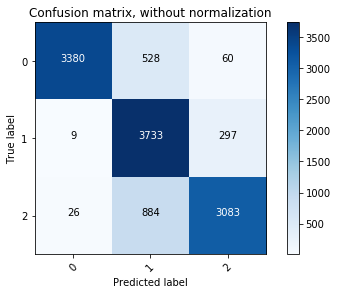

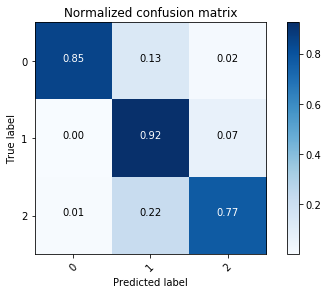

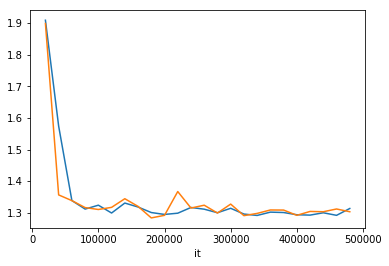

In [15]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 24, 'tanh',  label="H1")
h2 = network.Layer(24, 32, 'tanh',  label="H2")
h3 = network.Layer(32, 24, 'tanh', label="H3")
o = network.Layer(24, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(h2)
model.add_layer(h3)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=24, activation=sigmoid)
H2      (input=24, neurons=32, activation=sigmoid)
H3      (input=32, neurons=24, activation=sigmoid)
Output  (input=24, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 20000 Batch: 20000 Epoch 0 Train Loss: 1.90944769 lr: 0.900000 Val Loss: 1.90954215 Val Acc 0.33658333
It: 40000 Batch: 40000 Epoch 0 Train Loss: 1.90954214 lr: 0.900000 Val Loss: 1.90954208 Val Acc 0.33658333
It: 60000 Batch: 12000 Epoch 1 Train Loss: 1.90954336 lr: 0.720000 Val Loss: 1.90954222 Val Acc 0.33658333
It: 80000 Batch: 32000 Epoch 1 Train Loss: 1.90954299 lr: 0.720000 Val Loss: 1.90954228 Val Acc 0.33658333
It: 100000 Batch: 4000 Epoch 2 Train Loss: 1.90954205 lr: 0.576000 Val Loss: 1.90954221 Val Acc 0.33658333
It: 120000 Batch: 24000 Epoch 2 Train Loss: 1.90954276 lr: 0.576000 Val Loss: 1.90954224 Val Acc 0.33658333
It: 140000 Batch: 44000 Epoch 2 Train Loss: 1.90954250 lr: 0.5760

../utils/custom_scores.py:29: RuntimeWarning: invalid value encountered in long_scalars
  precision += TP / (TP + FP)


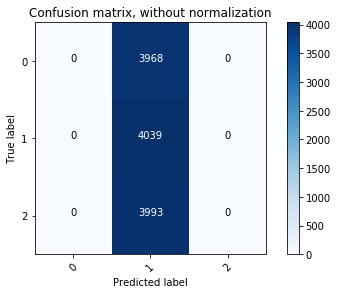

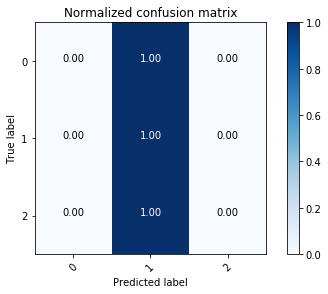

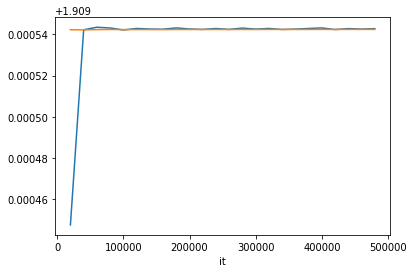

In [16]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

eps = np.finfo(np.float32).eps

h1 = network.Layer(nfeatures, 24, 'sigmoid',  label="H1")
h2 = network.Layer(24, 32, 'sigmoid',  label="H2")
h3 = network.Layer(32, 24, 'sigmoid', label="H3")
o = network.Layer(24, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(h2)
model.add_layer(h3)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=24, activation=relu)
H2      (input=24, neurons=32, activation=relu)
H3      (input=32, neurons=24, activation=relu)
Output  (input=24, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 20000 Batch: 20000 Epoch 0 Train Loss: 1.90944453 lr: 0.900000 Val Loss: 1.90954111 Val Acc 0.33066667
It: 40000 Batch: 40000 Epoch 0 Train Loss: 1.90954800 lr: 0.900000 Val Loss: 1.90954101 Val Acc 0.33075000
It: 60000 Batch: 12000 Epoch 1 Train Loss: 1.90954297 lr: 0.720000 Val Loss: 1.90954017 Val Acc 0.33066667
It: 80000 Batch: 32000 Epoch 1 Train Loss: 1.90954282 lr: 0.720000 Val Loss: 1.90954279 Val Acc 0.33066667
It: 100000 Batch: 4000 Epoch 2 Train Loss: 1.90954087 lr: 0.576000 Val Loss: 1.90954129 Val Acc 0.33066667
It: 120000 Batch: 24000 Epoch 2 Train Loss: 1.90954217 lr: 0.576000 Val Loss: 1.90954383 Val Acc 0.33066667
It: 140000 Batch: 44000 Epoch 2 Train Loss: 1.90954365 lr: 0.576000 Val Lo

../utils/custom_scores.py:29: RuntimeWarning: invalid value encountered in long_scalars
  precision += TP / (TP + FP)


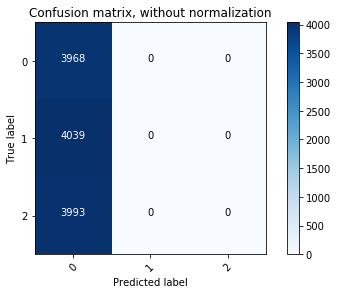

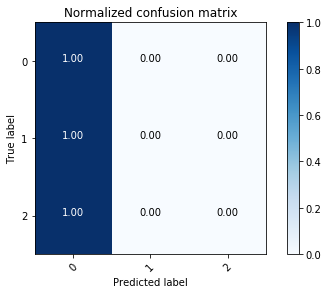

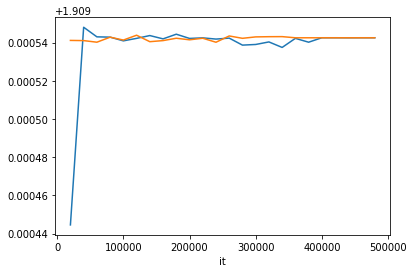

In [17]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)


network.DEBUG = False

h1 = network.Layer(nfeatures, 24, 'relu',  label="H1")
h2 = network.Layer(24, 32, 'relu',  label="H2")
h3 = network.Layer(32, 24, 'relu', label="H3")
o = network.Layer(24, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(h2)
model.add_layer(h3)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

## Using SMD 

Model Summary
-------------------------------
H1      (input=128, neurons=24, activation=tanh)
H2      (input=24, neurons=32, activation=tanh)
H3      (input=32, neurons=24, activation=tanh)
Output  (input=24, neurons=3, activation=sigmoid)
-------------------------------

Shuffled


../NN/activation_functions.py:41: RuntimeWarning: overflow encountered in exp
  return (2 / (1+np.exp(-2*h)))-1


It: 20000 Batch: 20000 Epoch 0 Train Loss: 0.66733621 lr: 0.900000 Val Loss: 0.45544104 Val Acc 0.40491667
It: 40000 Batch: 40000 Epoch 0 Train Loss: 0.47142116 lr: 0.900000 Val Loss: 0.46309196 Val Acc 0.41258333
It: 60000 Batch: 12000 Epoch 1 Train Loss: 0.46491209 lr: 0.720000 Val Loss: 0.45021678 Val Acc 0.41683333
It: 80000 Batch: 32000 Epoch 1 Train Loss: 0.43633573 lr: 0.720000 Val Loss: 0.32725713 Val Acc 0.64841667
It: 100000 Batch: 4000 Epoch 2 Train Loss: 0.34844888 lr: 0.576000 Val Loss: 0.29904185 Val Acc 0.64450000
It: 120000 Batch: 24000 Epoch 2 Train Loss: 0.33697861 lr: 0.576000 Val Loss: 0.37856917 Val Acc 0.40241667
It: 140000 Batch: 44000 Epoch 2 Train Loss: 0.34128883 lr: 0.576000 Val Loss: 0.33023701 Val Acc 0.64450000
It: 160000 Batch: 16000 Epoch 3 Train Loss: 0.32871362 lr: 0.460800 Val Loss: 0.30938309 Val Acc 0.64516667
It: 180000 Batch: 36000 Epoch 3 Train Loss: 0.32314097 lr: 0.460800 Val Loss: 0.35254541 Val Acc 0.64533333
It: 200000 Batch: 8000 Epoch 4 Tr

../utils/custom_scores.py:29: RuntimeWarning: invalid value encountered in long_scalars
  precision += TP / (TP + FP)


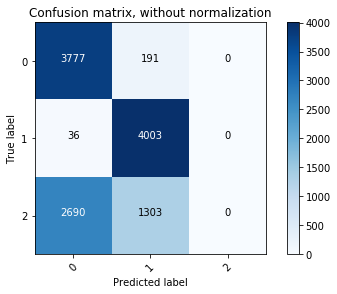

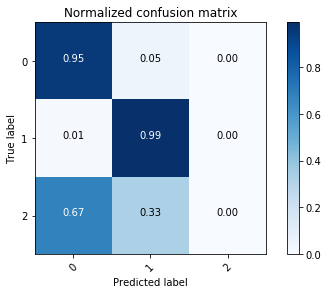

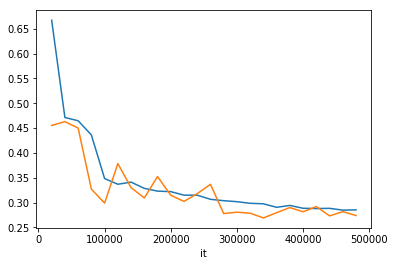

In [18]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 24, 'tanh',  label="H1")
h2 = network.Layer(24, 32, 'tanh',  label="H2")
h3 = network.Layer(32, 24, 'tanh', label="H3")
o = network.Layer(24, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(h2)
model.add_layer(h3)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=24, activation=sigmoid)
H2      (input=24, neurons=32, activation=sigmoid)
H3      (input=32, neurons=24, activation=sigmoid)
Output  (input=24, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 20000 Batch: 20000 Epoch 0 Train Loss: 0.78810091 lr: 0.900000 Val Loss: 0.41235604 Val Acc 0.33066667
It: 40000 Batch: 40000 Epoch 0 Train Loss: 0.47584875 lr: 0.900000 Val Loss: 0.40099896 Val Acc 0.33275000
It: 60000 Batch: 12000 Epoch 1 Train Loss: 0.46100326 lr: 0.720000 Val Loss: 0.54192605 Val Acc 0.33275000
It: 80000 Batch: 32000 Epoch 1 Train Loss: 0.45390197 lr: 0.720000 Val Loss: 0.47704924 Val Acc 0.33658333
It: 100000 Batch: 4000 Epoch 2 Train Loss: 0.44906330 lr: 0.576000 Val Loss: 0.51765818 Val Acc 0.33066667
It: 120000 Batch: 24000 Epoch 2 Train Loss: 0.43452862 lr: 0.576000 Val Loss: 0.38936212 Val Acc 0.33066667
It: 140000 Batch: 44000 Epoch 2 Train Loss: 0.43265033 lr: 0.5760

../utils/custom_scores.py:29: RuntimeWarning: invalid value encountered in long_scalars
  precision += TP / (TP + FP)


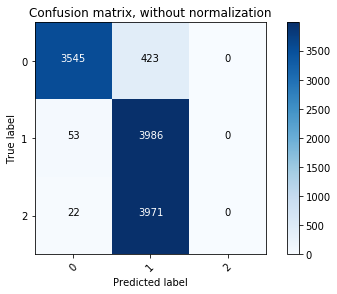

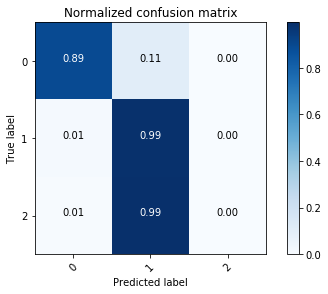

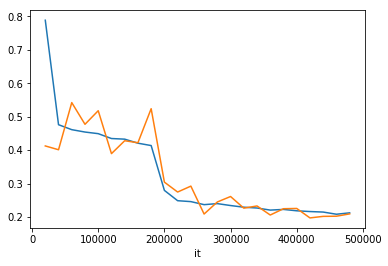

In [19]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 24, 'sigmoid',  label="H1")
h2 = network.Layer(24, 32, 'sigmoid',  label="H2")
h3 = network.Layer(32, 24, 'sigmoid', label="H3")
o = network.Layer(24, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(h2)
model.add_layer(h3)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

In [ ]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 24, 'relu',  label="H1")
h2 = network.Layer(24, 32, 'relu',  label="H2")
h3 = network.Layer(32, 24, 'relu', label="H3")
o = network.Layer(24, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(h2)
model.add_layer(h3)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=24, activation=relu)
H2      (input=24, neurons=32, activation=relu)
H3      (input=32, neurons=24, activation=relu)
Output  (input=24, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 20000 Batch: 20000 Epoch 0 Train Loss: 0.97009898 lr: 0.900000 Val Loss: 0.99463006 Val Acc 0.33066667
It: 40000 Batch: 40000 Epoch 0 Train Loss: 0.99446584 lr: 0.900000 Val Loss: 0.99702765 Val Acc 0.33066667


../NN/activation_functions.py:18: RuntimeWarning: overflow encountered in exp
  sig = 1. / (1. + np.exp(-h))


It: 60000 Batch: 12000 Epoch 1 Train Loss: 0.98837853 lr: 0.720000 Val Loss: 0.99869580 Val Acc 0.33066667
It: 80000 Batch: 32000 Epoch 1 Train Loss: 0.99824989 lr: 0.720000 Val Loss: 0.99869584 Val Acc 0.33066667
It: 100000 Batch: 4000 Epoch 2 Train Loss: 0.99856167 lr: 0.576000 Val Loss: 0.99869588 Val Acc 0.33066667
